# Demo Exercise

In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *
from demo.contextual_bandit_dgp import Complex, IHDP, Simple
from demo.reinforcement_learning.policy_gradient import PolicyGradient
from demo.reinforcement_learning.dqn import DQN
from demo.reinforcement_learning.actor_critic import ActorCritic
from demo.visualizations.comparison import performance_comparison_report, generate_comparison_plots

---
## 1. Setting Up the Data Generating Process (DGP)

In [2]:
# Type the number of arms and features
n_arms = int(input("Number of arms: "))
n_features = int(input("Number of features: "))

# Generate Data
dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=0.3)

print(f"DGP: {type(dgp).__name__}")
print(f"Number of arms: {n_arms}")
print(f"Number of features: {n_features}")


DGP: Simple
Number of arms: 4
Number of features: 3


---
## 2. Policy Gradient Method vs Random Assignment

In [3]:
# Type the number of rounds and batch size
n_rounds = int(input("Number of rounds: "))
batch_size = int(input("Batch size: "))

In [4]:
# Initialize the policy gradient model
policy = PolicyGradient(n_features=n_features, n_actions=n_arms, lr=1e-2)

# Storage for results
pg_rewards = []
pg_regrets = []
random_rewards = []
random_regrets = []
pg_optimal_rates = []
random_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Policy Gradient ---
    pg_actions, log_probs = policy.select_actions(contexts)
    pg_observed = dgp.r(pg_actions, contexts)
    policy.finish_batch(pg_observed, pg_actions, log_probs)

    pg_rewards.extend(pg_observed)
    pg_regrets.extend(optimal_rewards - pg_observed)
    pg_optimal_rates.append((pg_actions == optimal_arms).mean())

    # --- Random Assignment ---
    random_actions = np.random.randint(0, n_arms, size=batch_size)
    random_observed = dgp.r(random_actions, contexts)

    random_rewards.extend(random_observed)
    random_regrets.extend(optimal_rewards - random_observed)
    random_optimal_rates.append((random_actions == optimal_arms).mean())

# Convert to arrays
pg_rewards = np.array(pg_rewards)
pg_regrets = np.array(pg_regrets)
random_rewards = np.array(random_rewards)
random_regrets = np.array(random_regrets)
n_samples = len(pg_rewards)

print(f"Training complete: {n_rounds} rounds, {n_samples} total samples")

Training complete: 300 rounds, 9600 total samples


## Regret analysis

In [5]:
# Calculate cumulative regrets
pg_cumulative_regret = np.cumsum(pg_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

# Report performance comparison
report = performance_comparison_report(model1_rewards=pg_rewards,
                             model1_regrets=pg_regrets,
                             model1_cumulative_regret=pg_cumulative_regret,
                             model1_optimal_rates=pg_optimal_rates,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_cumulative_regret=random_cumulative_regret,
                             model2_optimal_rates=random_optimal_rates, )

In [6]:
# Create dictionary for generating plots
regrets_dict = {
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}



In [7]:
# Generate plots
p_cumulative_regret, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regrets_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window, )

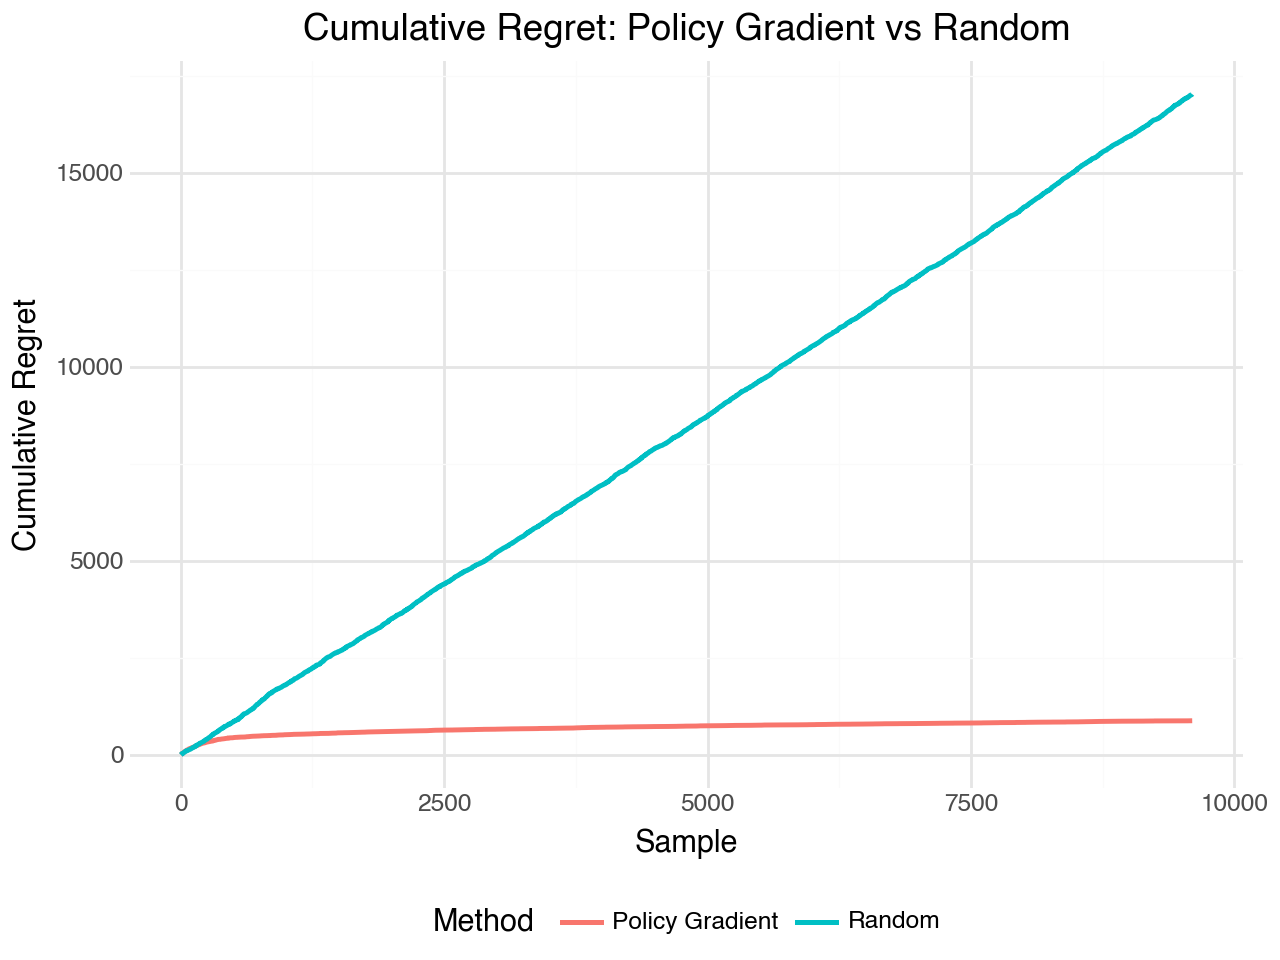

In [8]:
p_cumulative_regret

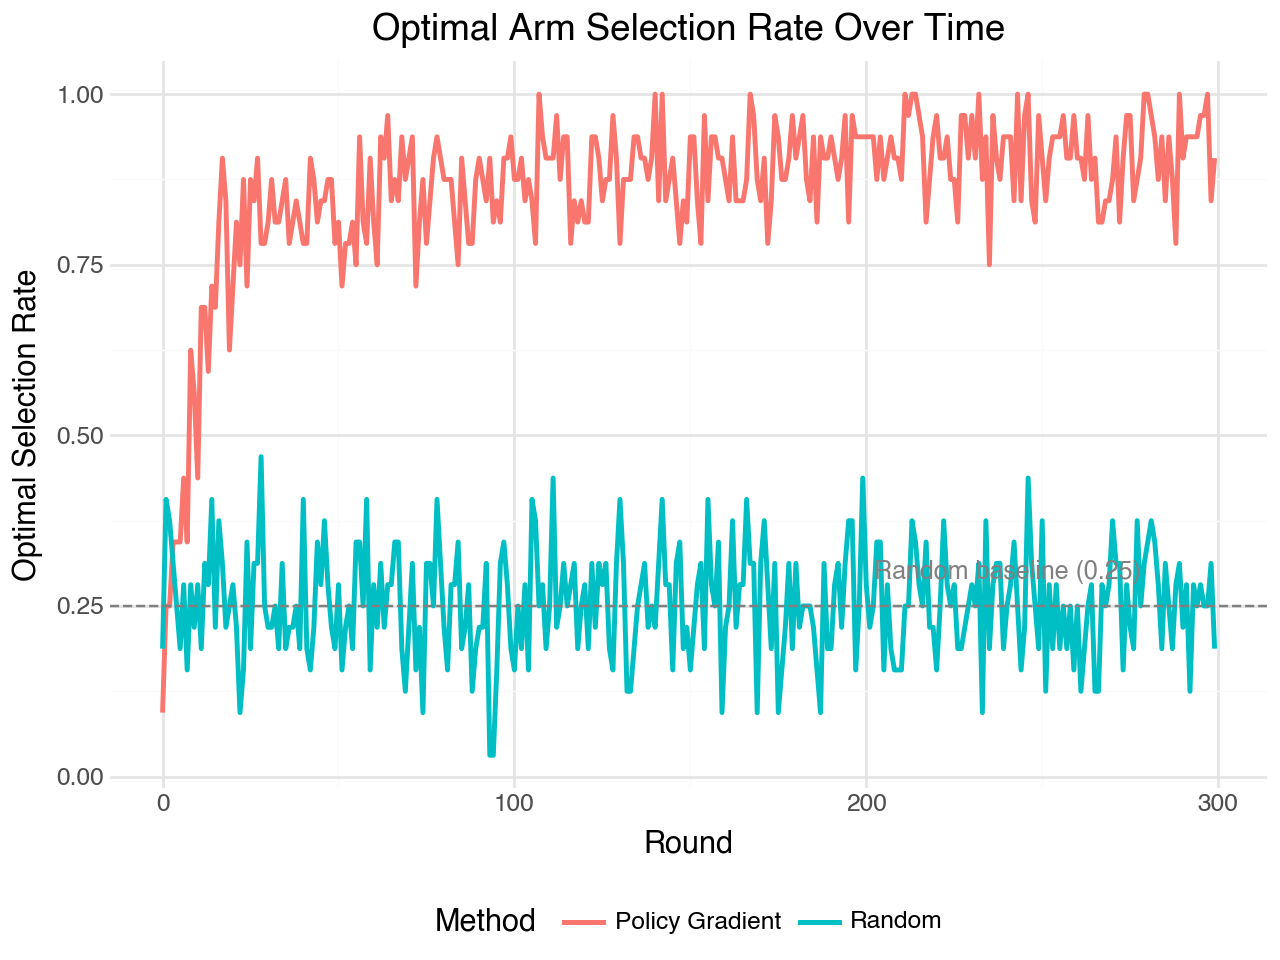

In [9]:
p_optimal_rate

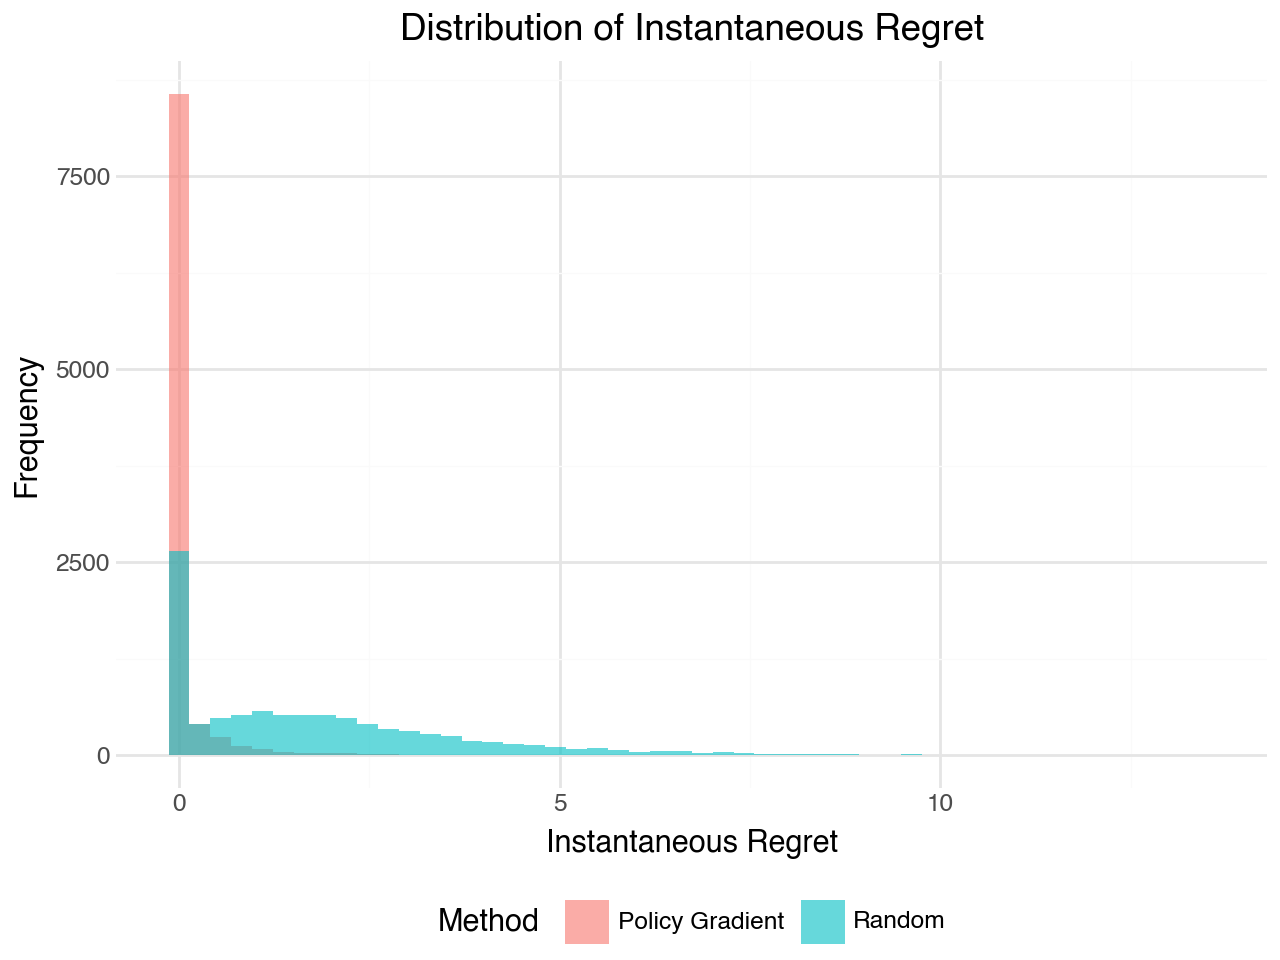

In [10]:
p_inst_regret

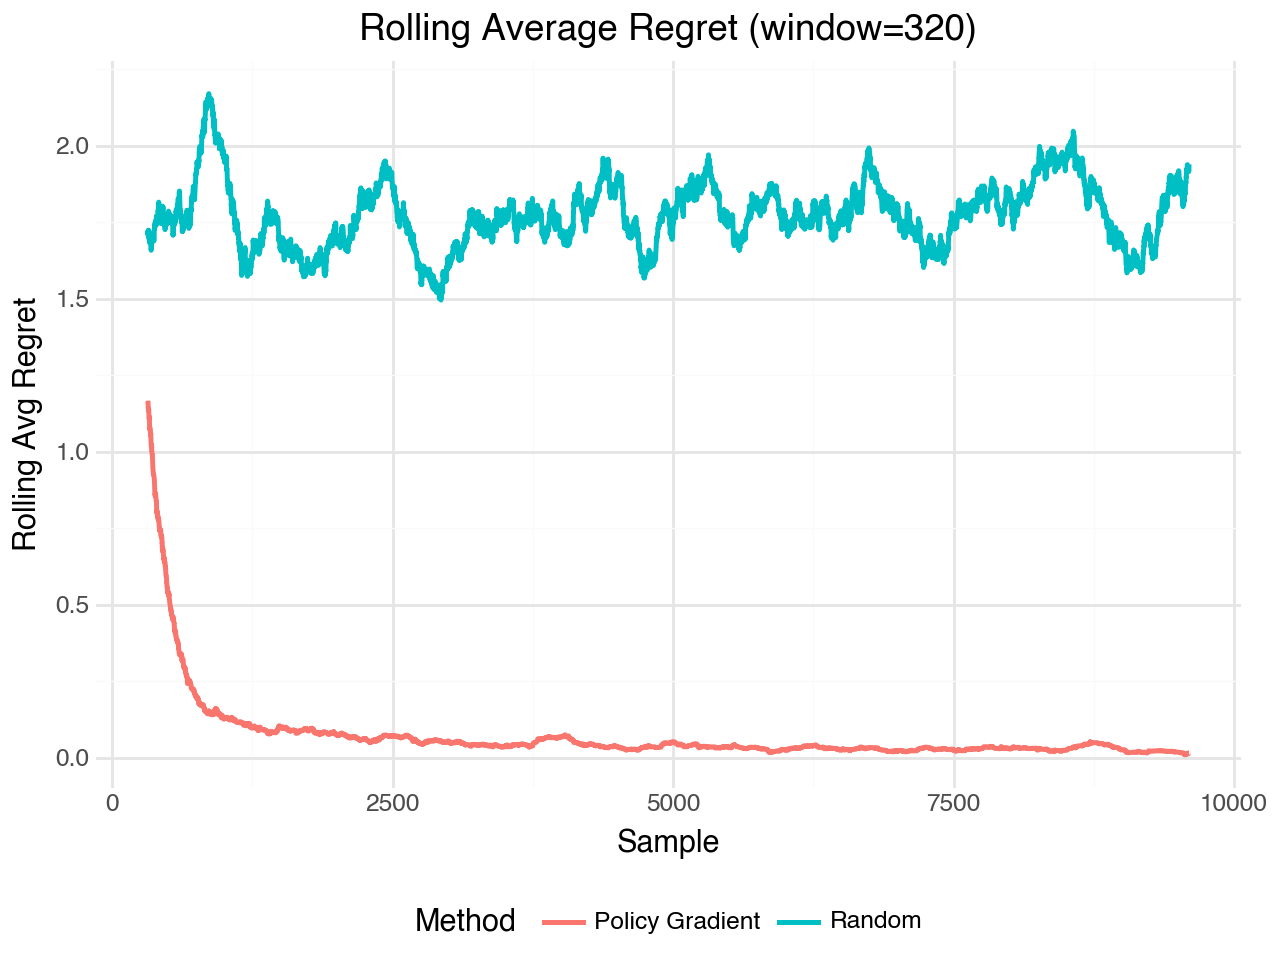

In [11]:
p_rolling

## 3. DQN vs Policy Gradient vs Random Assignment

In [12]:
# Type epsilon between 0 and 1
epsilon = float(input("Epsilon: "))

In [13]:
# Storage for results
dqn = DQN(n_features=n_features, n_actions=n_arms, lr=1e-2, epsilon=epsilon)
dqn_rewards = []
dqn_regrets = []
dqn_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- DQN ---
    dqn_actions = dqn.select_actions(contexts)
    dqn_observed = dgp.r(dqn_actions, contexts)

    # Update dqn
    dqn.finish_batch(rewards=dqn_observed, actions=dqn_actions, states=contexts)

    # Record dqn results
    dqn_rewards.extend(dqn_observed)
    dqn_regrets.extend(optimal_rewards - dqn_observed)
    dqn_optimal_rates.append((dqn_actions == optimal_arms).mean())

# Convert to arrays
dqn_rewards = np.array(dqn_rewards)
dqn_regrets = np.array(dqn_regrets)

n_samples = len(dqn_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 300 rounds, 9600 total samples


## Regret Analysis

In [14]:
dqn_cumulative_regret = np.cumsum(dqn_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

report = performance_comparison_report(model1_rewards=dqn_rewards,
                             model1_regrets=dqn_regrets,
                             model1_optimal_rates=dqn_optimal_rates,
                             model1_cumulative_regret=dqn_cumulative_regret,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_optimal_rates=random_optimal_rates,
                             model2_cumulative_regret=random_cumulative_regret, )
print(report)

PERFORMANCE COMPARISON

Model 1:
  Mean reward: 1.4823
  Mean regret: 0.4071
  Total cumulative regret: 3907.9645
  Final optimal arm rate: 100.00%

Model 2:
  Mean reward: 0.0847
  Mean regret: 1.7741
  Total cumulative regret: 17031.3161
  Mean optimal arm rate: 25.47%

Improvement:
  Regret reduction: 77.05%


In [15]:
# Create dictionary for generating plots

regret_dict = {
    'DQN': dqn_regrets,
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    'DQN': dqn_cumulative_regret,
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    'DQN': dqn_optimal_rates,
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
dqn_rolling = pd.Series(dqn_regrets).rolling(window=rolling_window).mean().values
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'DQN': dqn_rolling,
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}


In [16]:
# Generate plots
p_cumulative, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regret_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['DQN', 'Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window,)

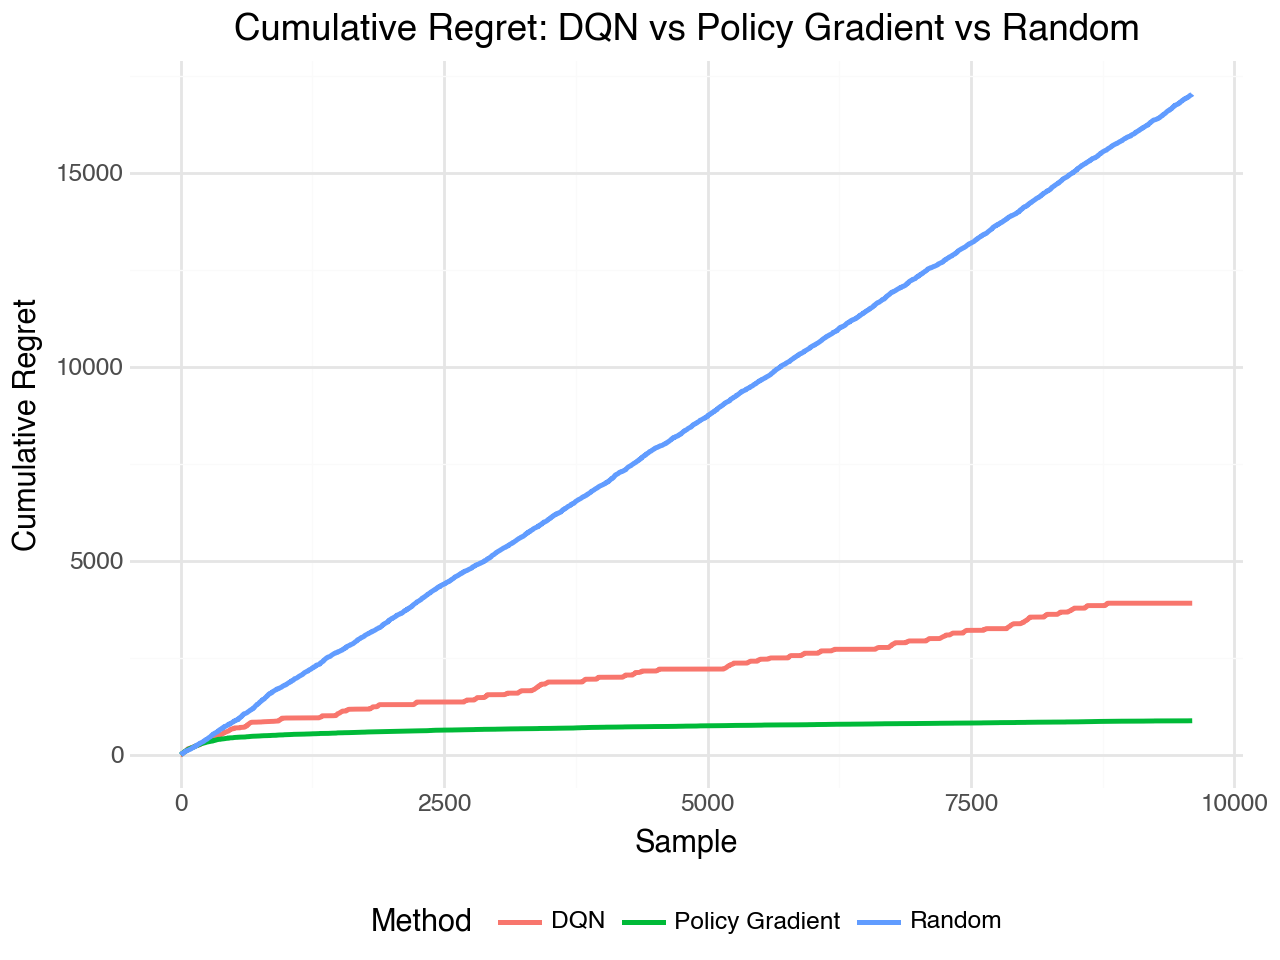

In [17]:
p_cumulative

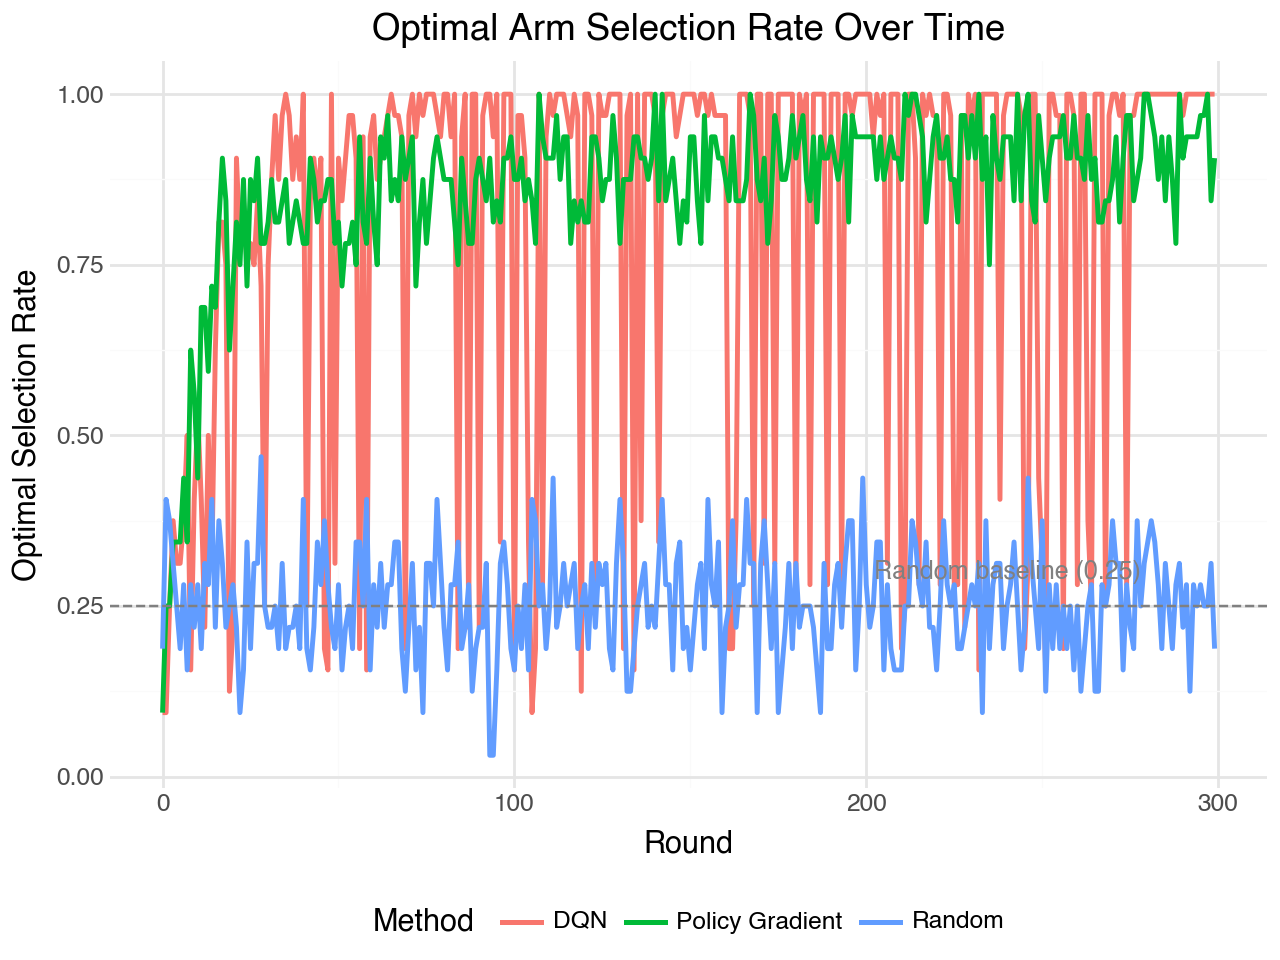

In [18]:
p_optimal_rate

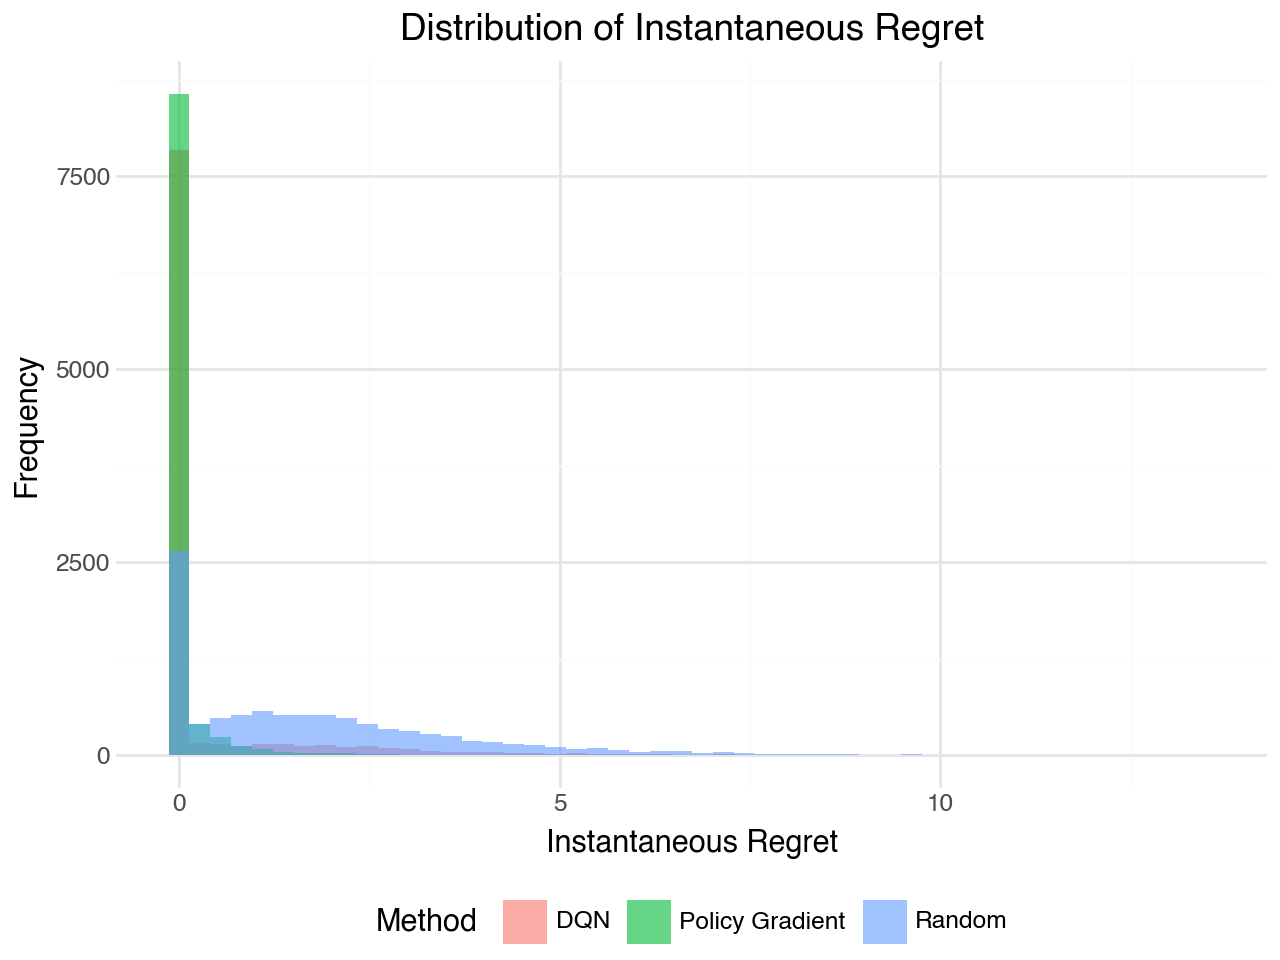

In [19]:
p_inst_regret

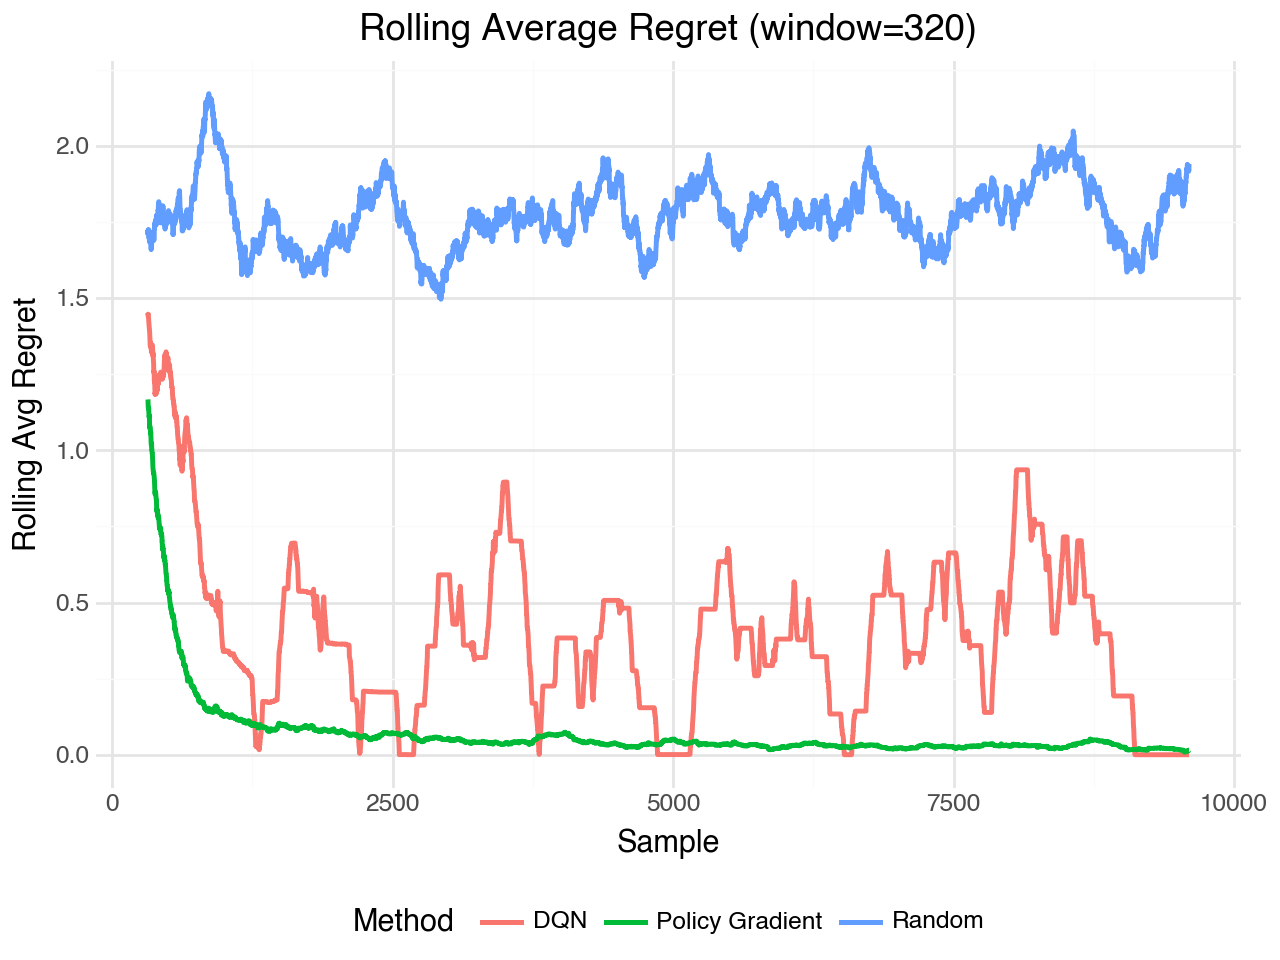

In [20]:
p_rolling

# 4. Actor-Critic vs DQN vs Policy Gradient vs Random Assignment

In [21]:
n_hidden_units = int(input("Number of hidden units: "))

In [22]:
actor_critic = ActorCritic(n_features=n_features, n_actions=n_arms, n_hidden_units=n_hidden_units, lr=1e-2)

# Storage for results
ac_rewards = []
ac_regrets = []
ac_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Actor-Critic ---
    ac_actions, log_probs = actor_critic.select_actions(contexts)
    ac_observed = dgp.r(ac_actions, contexts)

    # Update actor-critic
    actor_critic.finish_batch(rewards=ac_observed, actions=ac_actions, states=contexts, log_probs=log_probs)

    # Record actor-critic results
    ac_rewards.extend(ac_observed)
    ac_regrets.extend(optimal_rewards - ac_observed)
    ac_optimal_rates.append((ac_actions == optimal_arms).mean())

# Convert to arrays
ac_rewards = np.array(ac_rewards)
ac_regrets = np.array(ac_regrets)

n_samples = len(ac_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 300 rounds, 9600 total samples


## Regret Analysis

In [23]:
# Calculate cumulative regrets
ac_cumulative_regret = np.cumsum(ac_regrets)
random_cumulative_regret = np.cumsum(random_regrets)

report = performance_comparison_report(model1_rewards=ac_rewards,
                             model1_regrets=ac_regrets,
                             model1_optimal_rates=ac_optimal_rates,
                             model1_cumulative_regret=ac_cumulative_regret,
                             model2_rewards=random_rewards,
                             model2_regrets=random_regrets,
                             model2_optimal_rates=random_optimal_rates,
                             model2_cumulative_regret=random_cumulative_regret, )
print(report)

PERFORMANCE COMPARISON

Model 1:
  Mean reward: 1.7583
  Mean regret: 0.1291
  Total cumulative regret: 1239.5039
  Final optimal arm rate: 90.62%

Model 2:
  Mean reward: 0.0847
  Mean regret: 1.7741
  Total cumulative regret: 17031.3161
  Mean optimal arm rate: 25.47%

Improvement:
  Regret reduction: 92.72%


In [24]:
# Create dictionary for generating plots

regret_dict = {
    "Actor-Critic": ac_regrets,
    'DQN': dqn_regrets,
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    "Actor-Critic": ac_cumulative_regret,
    'DQN': dqn_cumulative_regret,
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    "Actor-Critic": ac_optimal_rates,
    'DQN': dqn_optimal_rates,
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
ac_rolling = pd.Series(ac_regrets).rolling(window=rolling_window).mean().values
dqn_rolling = pd.Series(dqn_regrets).rolling(window=rolling_window).mean().values
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'Actor-Critic': ac_rolling,
    'DQN': dqn_rolling,
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}


In [25]:
p_cumulative, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regret_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['Actor-Critic', 'DQN', 'Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window,)

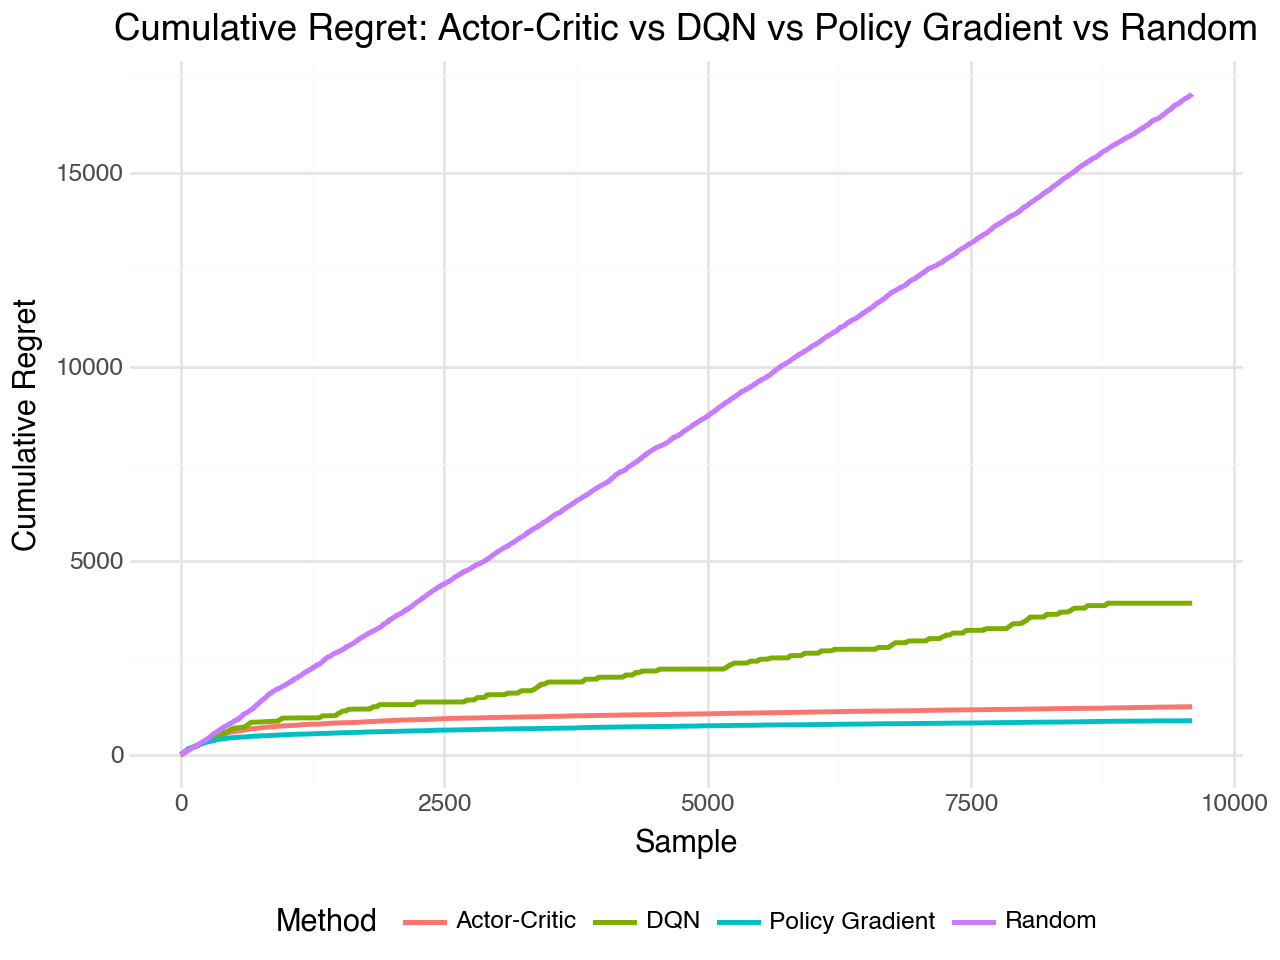

In [26]:
p_cumulative

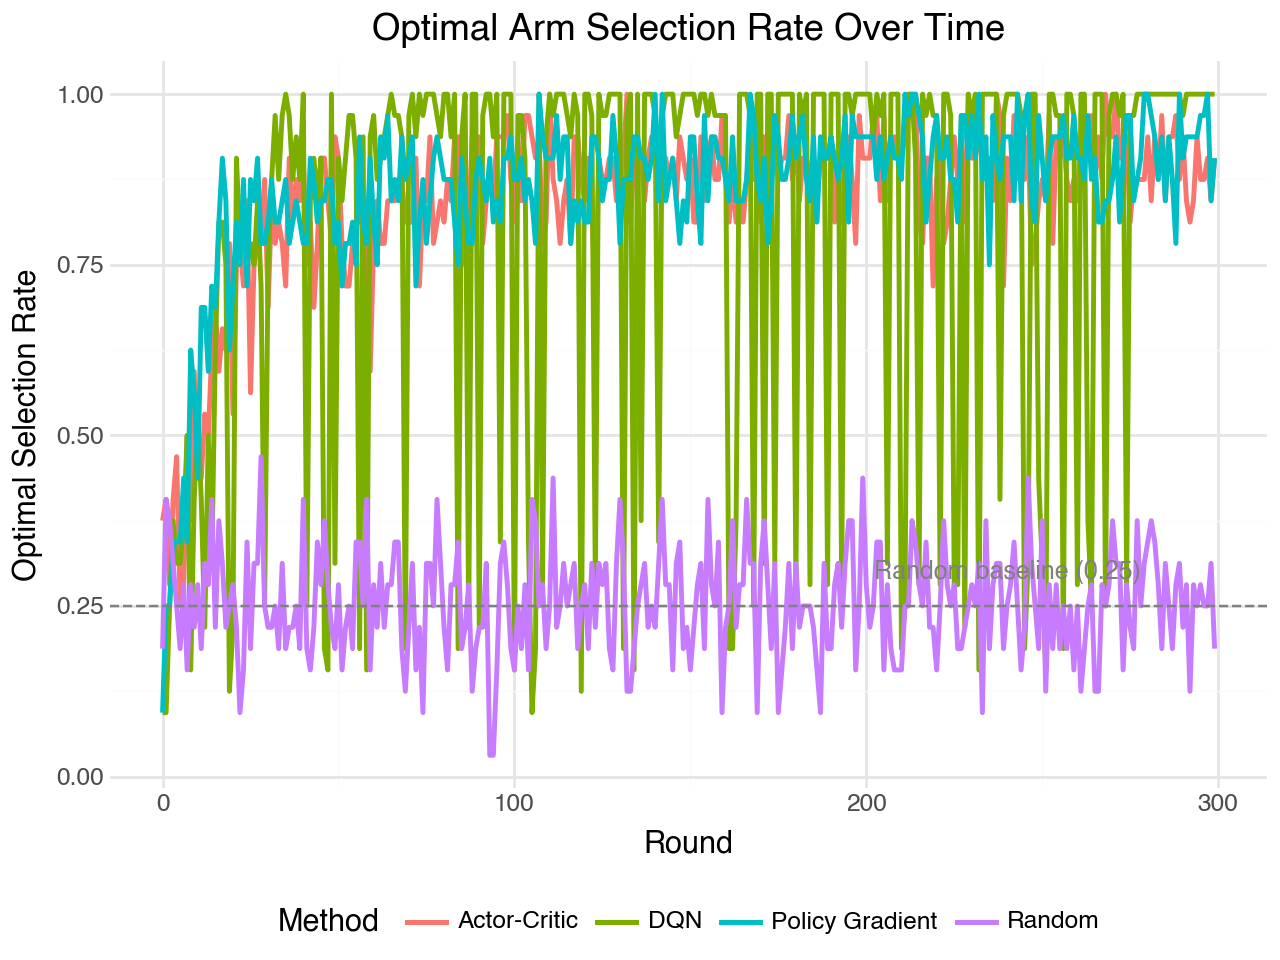

In [27]:
p_optimal_rate

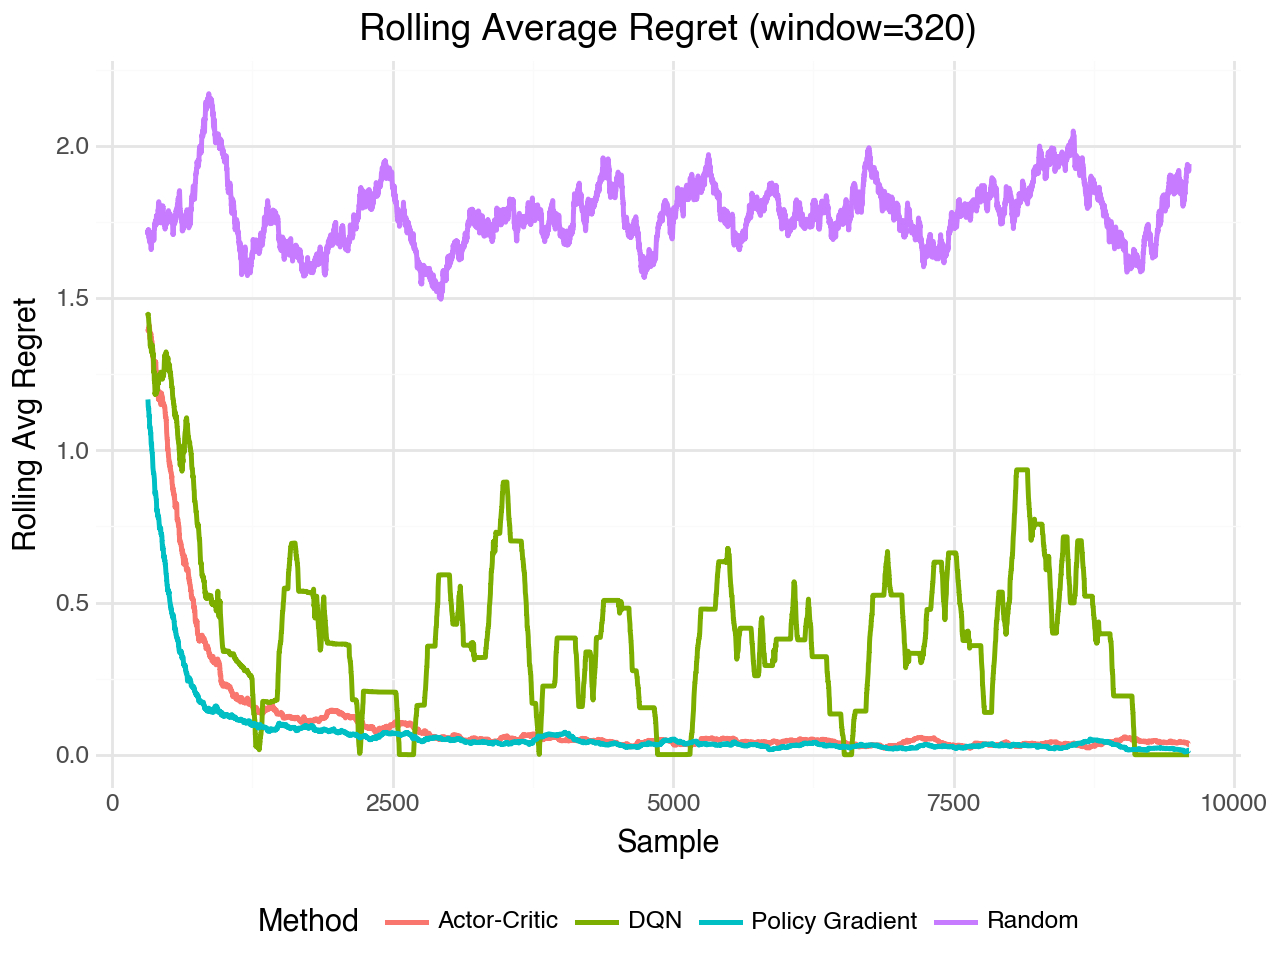

In [28]:
p_rolling

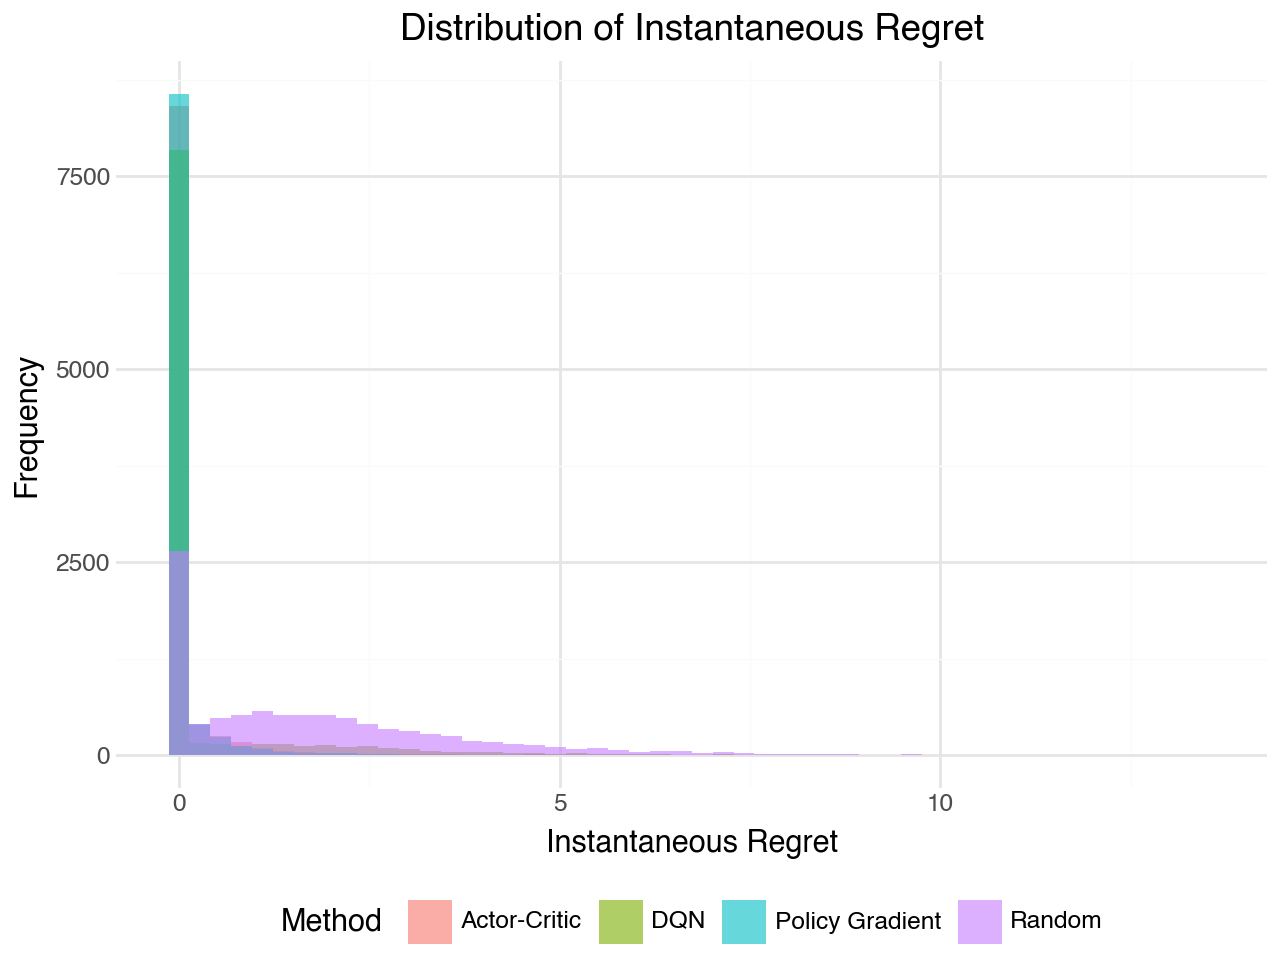

In [29]:
p_inst_regret